<a href="https://colab.research.google.com/github/juanmadeira/pytorch/blob/main/01_pytorch_workflow_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Create a straight line dataset using the linear regression formula (weight * X + bias).

- Set weight=0.3 and bias=0.9 there should be at least 100 datapoints total.
- Split the data into 80% training, 20% testing.
- Plot the training and testing data so it becomes visual.

In [276]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.8.0+cu126'

In [277]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [278]:
weight = 0.3
bias = 0.9

X = torch.arange(0,1, 0.01).unsqueeze(dim = 1)
y = weight * X + bias

print(f"Number of X samples: {len(X)}")
print(f"Number of y samples: {len(y)}")
print(f"\nFirst 10 X & y samples:\nX: {X[:10]}\ny: {y[:10]}")

Number of X samples: 100
Number of y samples: 100

First 10 X & y samples:
X: tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400],
        [0.0500],
        [0.0600],
        [0.0700],
        [0.0800],
        [0.0900]])
y: tensor([[0.9000],
        [0.9030],
        [0.9060],
        [0.9090],
        [0.9120],
        [0.9150],
        [0.9180],
        [0.9210],
        [0.9240],
        [0.9270]])


In [279]:
train_split = int(len(X) * 0.8)

X_train = X[:train_split]
y_train = y[:train_split]
X_test = X[train_split:]
y_test = y[train_split:]

len(X_train),len(y_train),len(X_test),len(y_test)

(80, 80, 20, 20)

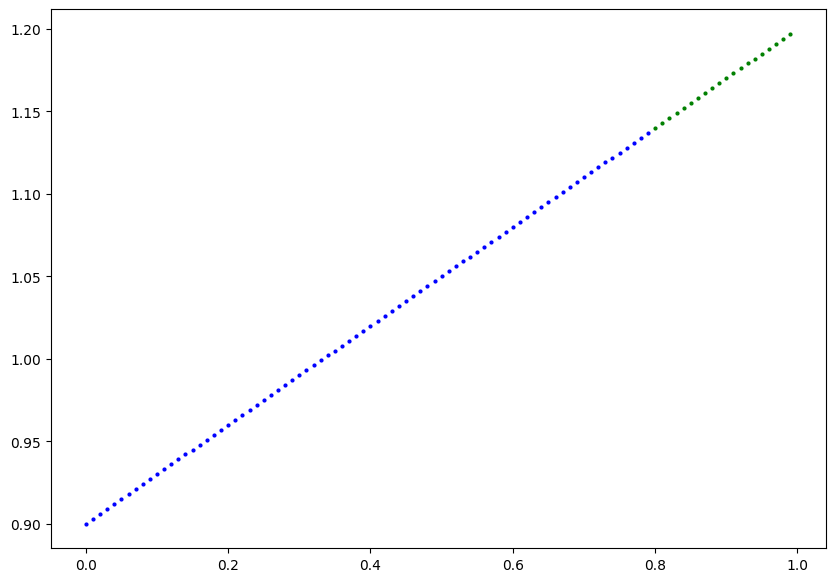

In [280]:
def plot_predictions(train_data = X_train,
                 train_labels = y_train,
                 test_data = X_test,
                 test_labels = y_test,
                 predictions = None):
    plt.figure(figsize = (10,7))
    plt.scatter(train_data,train_labels,c = 'b',s = 4,label = "Training data")
    plt.scatter(test_data,test_labels,c = 'g',s = 4,label = "Test data")

    if predictions is not None:
        plt.scatter(test_data,predictions,c = 'r',s = 4,label = "Predictions")
        plt.legend(prop = {"size" : 14})

plot_predictions()

2. Build a PyTorch model by subclassing `nn.Module`.

- Inside should be a randomly initialized `nn.Parameter()` with `requires_grad=True`, one for weights and one for bias.
- Implement the `forward()` method to compute the linear regression function you used to create the dataset in 1.
- Once you've constructed the model, make an instance of it and check its `state_dict()`.
> Note: If you'd like to use `nn.Linear()` instead of `nn.Parameter()` you can.

In [281]:
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weight = nn.Parameter(data=torch.randn(1,
                                              requires_grad=True,
                                              dtype=torch.float
                                              ))

    self.bias = nn.Parameter(data=torch.randn(1,
                                              requires_grad=True,
                                              dtype=torch.float
                                              ))

  def forward(self, x):
    return self.weight * x + self.bias

torch.manual_seed(42)
model_1 = LinearRegressionModel()
model_1,model_1.state_dict()

(LinearRegressionModel(),
 OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))]))

In [282]:
next(model_1.parameters()).device

device(type='cpu')

In [283]:
model_1.to(device)
list(model_1.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

3. Create a loss function and optimizer using `nn.L1Loss()` and `torch.optim.SGD(params, lr)` respectively

- Set the learning rate of the optimizer to be 0.01 and the parameters to optimize should be the model parameters from the model you created in 2.
- Write a training loop to perform the appropriate training steps for 300 epochs.
- The training loop should test the model on the test dataset every 20 epochs.


In [284]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params = model_1.parameters(),
                            lr = 0.01)

In [285]:
torch.manual_seed(42)

epochs = 501

# Send data to target device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training

    # Put model in train mode
    model_1.train()

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred,y_train)

    # 3. Zero gradients
    optimizer.zero_grad()

    # 4. Backpropagation
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Perform testing every 20 epochs
    if epoch % 50 == 0:
        # Put model in evaluation mode and setup inference context
        model_1.eval()
        with torch.inference_mode():
            # 1. Forward pass
            y_preds = model_1(X_test)
            # 2. Calculate test loss
            test_loss = loss_fn(y_preds,y_test)
            # Print out what's happening
            print(f"Epoch: {epoch} | Train loss: {loss:.3f} | Test loss: {test_loss:.3f}")

Epoch: 0 | Train loss: 0.757 | Test loss: 0.725
Epoch: 50 | Train loss: 0.179 | Test loss: 0.048
Epoch: 100 | Train loss: 0.046 | Test loss: 0.105
Epoch: 150 | Train loss: 0.028 | Test loss: 0.066
Epoch: 200 | Train loss: 0.011 | Test loss: 0.026
Epoch: 250 | Train loss: 0.004 | Test loss: 0.006
Epoch: 300 | Train loss: 0.004 | Test loss: 0.006
Epoch: 350 | Train loss: 0.004 | Test loss: 0.006
Epoch: 400 | Train loss: 0.004 | Test loss: 0.006
Epoch: 450 | Train loss: 0.004 | Test loss: 0.006
Epoch: 500 | Train loss: 0.004 | Test loss: 0.006


4. Make predictions with the trained model on the test data.

- Visualize these predictions against the original training and testing data (note: you may need to make sure the predictions are not on the GPU if you want to use non-CUDA-enabled libraries such as matplotlib to plot).

In [286]:
model_1.eval()

with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[1.1333],
        [1.1363],
        [1.1393],
        [1.1423],
        [1.1454],
        [1.1484],
        [1.1514],
        [1.1544],
        [1.1575],
        [1.1605],
        [1.1635],
        [1.1666],
        [1.1696],
        [1.1726],
        [1.1756],
        [1.1787],
        [1.1817],
        [1.1847],
        [1.1877],
        [1.1908]])

In [287]:
y_preds.cpu()

tensor([[1.1333],
        [1.1363],
        [1.1393],
        [1.1423],
        [1.1454],
        [1.1484],
        [1.1514],
        [1.1544],
        [1.1575],
        [1.1605],
        [1.1635],
        [1.1666],
        [1.1696],
        [1.1726],
        [1.1756],
        [1.1787],
        [1.1817],
        [1.1847],
        [1.1877],
        [1.1908]])

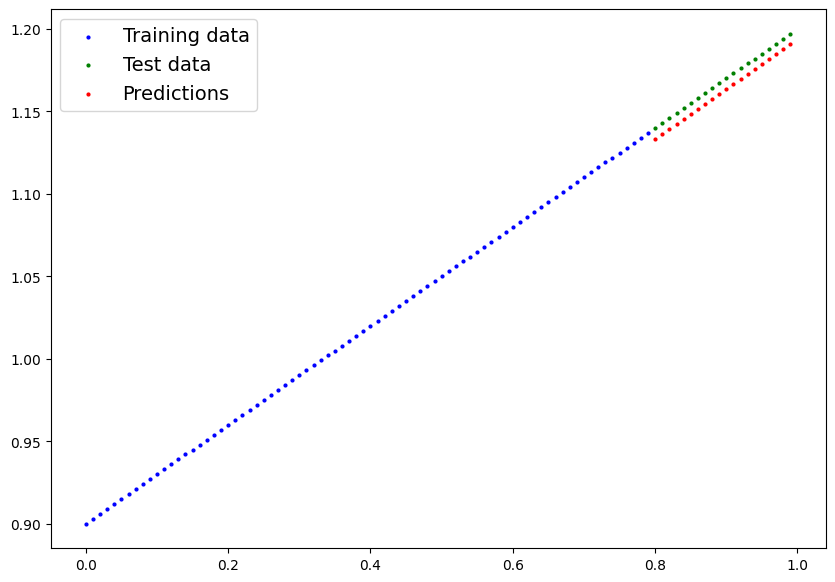

In [288]:
plot_predictions(predictions = y_preds.cpu())

5. Save your trained model's `state_dict()`o file.

- Create a new instance of your model class you made in 2. and load in the `state_dict()` you just saved to it.
- Perform predictions on your test data with the loaded model and confirm they match the original model predictions from 4.

In [289]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True,exist_ok = True)

MODEL_NAME = "01_pytorch_model"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj = model_1.state_dict(),f = MODEL_SAVE_PATH)

Saving model to models/01_pytorch_model


In [290]:
loaded_model = LinearRegressionModel()
loaded_model.load_state_dict(torch.load(f = MODEL_SAVE_PATH))
loaded_model.to(device)

LinearRegressionModel()

In [291]:
y_preds_new = loaded_model(X_test)
y_preds == y_preds_new

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

In [292]:
loaded_model.state_dict()

OrderedDict([('weight', tensor([0.3027])), ('bias', tensor([0.8911]))])